In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [3]:
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/batch_corrected/Hao_PBMC_Harmony_unscaled.h5ad')
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(' ', '_')
labels = adata.obs['celltype.l2']
types = np.unique(labels).tolist()
types

['ASDC',
 'B_intermediate',
 'B_memory',
 'B_naive',
 'CD14_Mono',
 'CD16_Mono',
 'CD4_CTL',
 'CD4_Naive',
 'CD4_Proliferating',
 'CD4_TCM',
 'CD4_TEM',
 'CD8_Naive',
 'CD8_Proliferating',
 'CD8_TCM',
 'CD8_TEM',
 'Doublet',
 'Eryth',
 'HSPC',
 'ILC',
 'MAIT',
 'NK',
 'NK_CD56bright',
 'NK_Proliferating',
 'Plasmablast',
 'Platelet',
 'Treg',
 'cDC1',
 'cDC2',
 'dnT',
 'gdT',
 'pDC']

## Count ADlasso features

In [4]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/feature_selection_v3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

skipping: ASDC
skipping: B_intermediate
skipping: B_memory
skipping: B_naive
skipping: CD14_Mono
skipping: CD16_Mono
skipping: CD4_CTL
skipping: CD4_Naive
skipping: CD4_Proliferating
skipping: CD4_TCM
skipping: CD4_TEM
skipping: CD8_Naive
skipping: CD8_TEM
skipping: Doublet
skipping: Eryth
skipping: HSPC
skipping: MAIT
skipping: NK
skipping: NK_CD56bright
skipping: NK_Proliferating
skipping: Plasmablast
skipping: Platelet
skipping: cDC1
skipping: cDC2
skipping: gdT
skipping: pDC


,Feature_count,Positive_feature_count
CD8_Proliferating,29,14
CD8_TCM,333,104
ILC,57,23
Treg,282,153
dnT,55,25


## Evaluate by DEGn

In [5]:
def LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    # print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)
    # print("Precision: {:.2f}%".format(precision * 100))
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # print("F1: {:.2f}%".format(f1 * 100))
    roc_auc = roc_auc_score(y_test, y_score)
    # print('ROC-AUC:', roc_auc)
    average_precision = average_precision_score(y_test, y_score)  # PR-AUC
    mcc = matthews_corrcoef(y_test, y_pred)

    # model metrics
    metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]

    return clf, metrics

In [7]:
queue = count_df.index.tolist()
queue

['CD8_Proliferating', 'CD8_TCM', 'ILC', 'Treg', 'dnT']

In [8]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/DEG_L2/DEG_table')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in queue:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG1000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics = LR_classifier(adata, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics

Constructing classifier for: CD8_Proliferating
n: 29
(161764, 29)
Constructing classifier for: CD8_TCM
n: 333
(161764, 333)
Constructing classifier for: ILC
n: 57
(161764, 57)
Constructing classifier for: Treg
n: 282
(161764, 282)
Constructing classifier for: dnT
n: 55
(161764, 55)


In [9]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
CD8_Proliferating,0.999351,0.285714,0.111111,0.160000,0.998440,0.199928,0.177896
CD8_TCM,0.988595,0.766667,0.518198,0.618407,0.981422,0.664005,0.624986
ILC,0.999753,0.875000,0.807692,0.840000,0.999826,0.857871,0.840550
Treg,0.994653,0.892344,0.744511,0.811752,0.994213,0.879027,0.812478
dnT,0.998671,0.868421,0.464789,0.605505,0.978452,0.604154,0.634785


In [12]:
import copy
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/DEG_L2')
# all_metrics_DEG.to_csv('L2_Harmony_DEGn_metrics_v3.csv')

v3_metrics_DEG = copy.deepcopy(all_metrics_DEG)
del all_metrics_DEG

In [19]:
all_metrics_DEG = pd.read_csv('L2_Harmony_DEGn_metrics.csv', index_col=0)
all_metrics_DEG.update(v3_metrics_DEG)
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999969,1.000000,0.933333,0.965517,0.999998,0.995833,0.966077
B_intermediate,0.985689,0.575163,0.181070,0.275430,0.982814,0.433344,0.317425
B_memory,0.991284,0.810945,0.744292,0.776190,0.995257,0.866338,0.772492
B_naive,0.993942,0.929847,0.944301,0.937018,0.998987,0.975481,0.933867
CD14_Mono,0.989893,0.977661,0.984188,0.980914,0.998774,0.995155,0.974050
CD16_Mono,0.993262,0.918400,0.908228,0.913286,0.998512,0.954303,0.909796
CD4_CTL,0.992304,0.691406,0.510086,0.587065,0.991078,0.640335,0.590154
CD4_Naive,0.965475,0.846692,0.830950,0.838747,0.987832,0.905246,0.819462
CD4_Proliferating,0.999505,0.607143,0.772727,0.680000,0.984514,0.733350,0.684711
CD4_TCM,0.946651,0.754265,0.623573,0.682721,0.968945,0.749859,0.657412


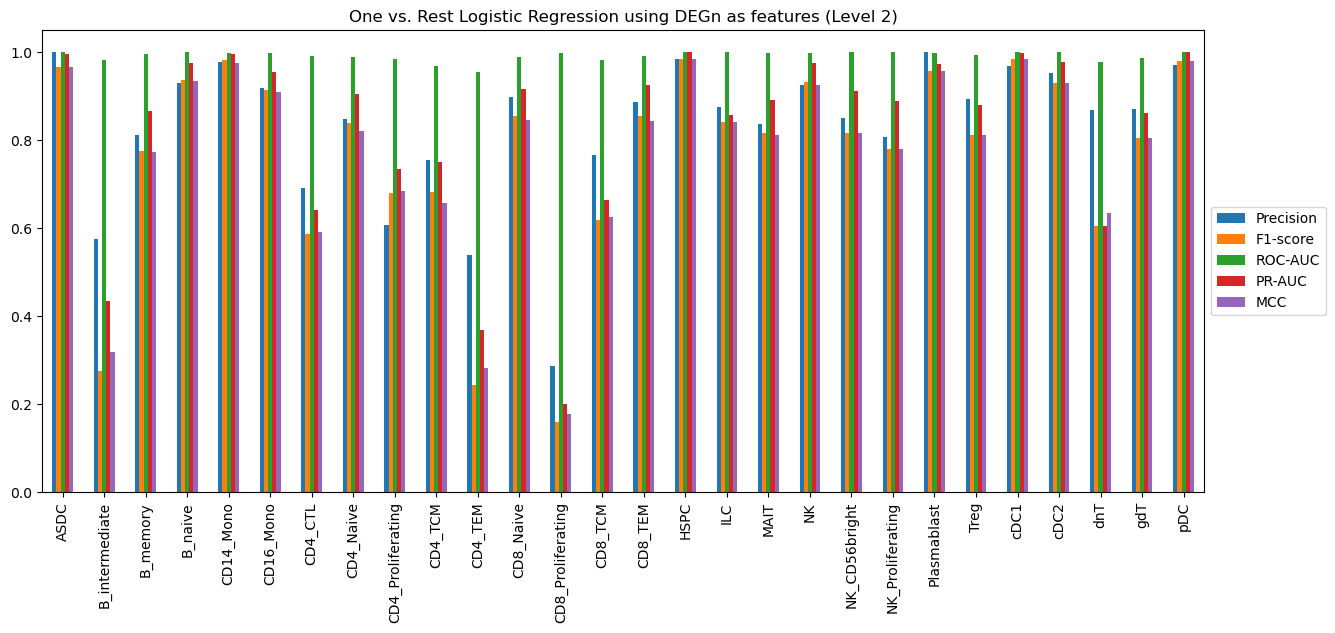

In [20]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']

irrelevant = ['Doublet', 'Eryth', 'Platelet']
all_metrics_DEG = all_metrics_DEG.drop(irrelevant, axis=0)

# Plot metrics for each celltype
ax = all_metrics_DEG[cols].plot.bar(rot=90, figsize=(15,6), title='One vs. Rest Logistic Regression using DEGn as features (Level 2)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Combine plots: ADlasso features vs. DEG

In [21]:
all_metrics_PreLect = pd.read_csv('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/LR_classifiers/LR_metrics_l2_v3.csv', index_col=0)
all_metrics_PreLect

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999932,0.948214,0.907500,0.926808,0.999967,0.966549,0.927299
B_intermediate,0.990227,0.750139,0.527343,0.616392,0.992717,0.706131,0.622816
B_memory,0.996384,0.919807,0.901065,0.909802,0.998887,0.964878,0.908287
B_naive,0.995259,0.950747,0.950245,0.950277,0.999346,0.985974,0.947909
CD14_Mono,0.989584,0.976625,0.984118,0.980341,0.998726,0.994310,0.973284
CD16_Mono,0.993651,0.917285,0.921361,0.919157,0.998560,0.953789,0.915943
CD4_CTL,0.996241,0.855157,0.785162,0.817115,0.997504,0.900380,0.816770
CD4_Naive,0.971984,0.875374,0.868928,0.871178,0.991701,0.936805,0.856080
CD4_Proliferating,0.999666,0.800373,0.704762,0.735750,0.999818,0.864085,0.743847
CD4_TCM,0.963793,0.824497,0.783596,0.799850,0.986991,0.880312,0.782509


In [22]:
irrelevant = ['Doublet', 'Eryth', 'Platelet']
all_metrics_PreLect = all_metrics_PreLect.drop(irrelevant, axis=0)

PreLect_minus_DEG = all_metrics_PreLect - all_metrics_DEG
PreLect_minus_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,-0.000037,-0.051786,-0.025833,-0.038710,-3.092349e-05,-0.029284,-0.038778
B_intermediate,0.004537,0.174976,0.346273,0.340961,9.902388e-03,0.272787,0.305391
B_memory,0.005100,0.108862,0.156773,0.133612,3.629951e-03,0.098540,0.135795
B_naive,0.001317,0.020900,0.005944,0.013259,3.585989e-04,0.010494,0.014042
CD14_Mono,-0.000309,-0.001037,-0.000070,-0.000573,-4.824343e-05,-0.000845,-0.000766
CD16_Mono,0.000389,-0.001115,0.013133,0.005872,4.825154e-05,-0.000514,0.006148
CD4_CTL,0.003938,0.163751,0.275075,0.230050,6.426625e-03,0.260045,0.226616
CD4_Naive,0.006509,0.028682,0.037979,0.032431,3.869154e-03,0.031558,0.036618
CD4_Proliferating,0.000161,0.193230,-0.067965,0.055750,1.530410e-02,0.130735,0.059136
CD4_TCM,0.017142,0.070233,0.160024,0.117129,1.804584e-02,0.130453,0.125097


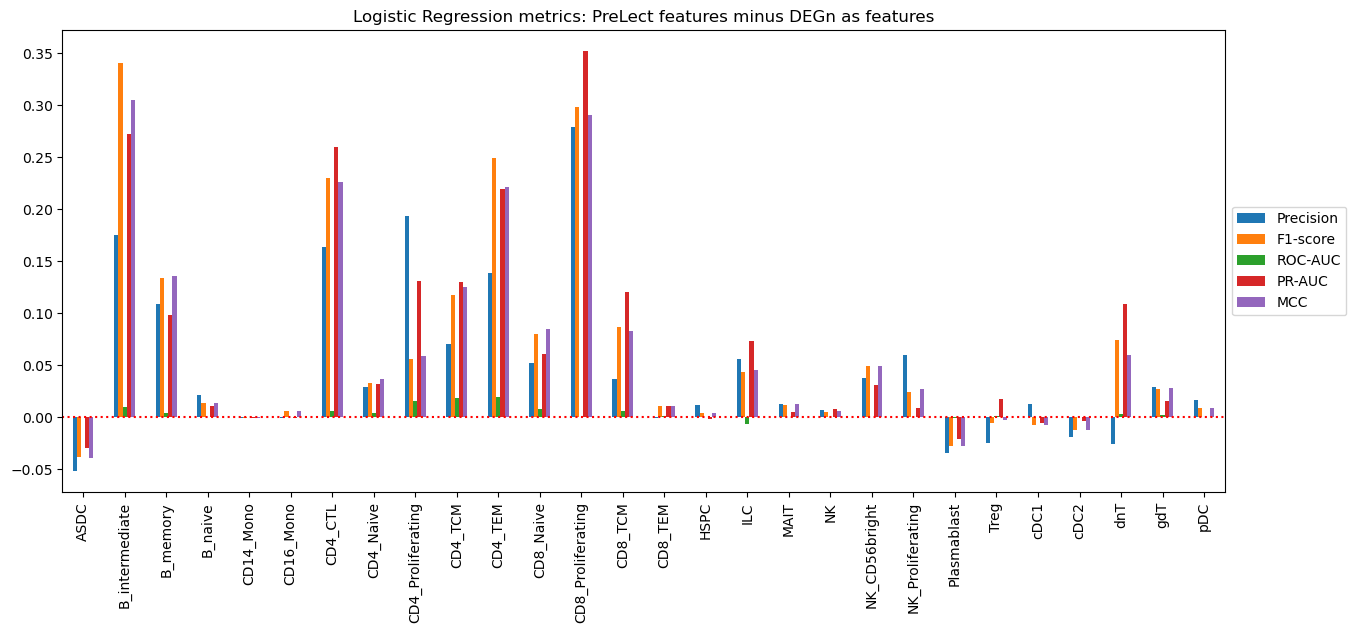

In [24]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = PreLect_minus_DEG[cols].plot.bar(rot=90, figsize=(15,6), title='Logistic Regression metrics: PreLect features minus DEGn as features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Add vertical red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')
